The quantum Fourier trasform is the basis of my of the most successuful quantum algorithms including Schor's algoritm for factroing prime numbers. In this notebook I derive the circuit the circit for the quantum fourier trasform (QFT), implement it in qiskit form first principes and then demonstrate that it works the same way as the inbuilt qiskit.QFT function.


What the Fourier trasform does is a change of basis form the computatinal $\{|0\rangle, |1\rangle\}$ basis states to the Fourier basis of $\left\{|+\rangle = \frac{|0\rangle +  |1\rangle\}}{\sqrt{2}}, |1\rangle\} = \frac{|0\rangle -  |1\rangle\}}{\sqrt{2}} \right\}$.


It best visulaised on a bloch sphere. In the computational bases, classical bits are encoded basically as a binary scheme e.g the state representing the number 4 may be encoded as $|4 \rangle = |100\rangle$. In the Fourier basis classical information is encoded as not 0 1 binaries but as point along the equator of the bloch sphere. There is a very nice visulaisation about this change of bases in the qiskit textbook, it gets across the idea of rotoation captured by the complex exponetial veru well. See 2.1 Counting in the Fourier basis: https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform 


For a single qubit the QFT maps exactly as the Hadamard gate: $QFT|0\rangle = H|0\rangle = |+\rangle $ and $QFT|1\rangle = H|1\rangle = |-\rangle $. Now we proceed with the generalisation of the Quantum fourier transform to $n$ qubists living in a $N = 2^n$ dimensinal Hilbert space. We define the QFT just as the Dicrete Fourier Trasfrom (DFT) in classical computing. 


$$
QFT|x\rangle=|\tilde{x}\rangle=\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{\frac{2 \pi i x y}{N}}|y\rangle, 
$$

where we think of both $|x\rangle$ and $|y\rangle$ as sperable quantum states, i.e ones that can be witten as a tensor product of qubits  $|x\rangle = | x_1 x_2 \dots x_n \rangle$ and $|y\rangle = | y_1 y_2 \dots y_n \rangle$.

In the sum we use the same sort of binary convention to decode $|y\rangle$ into a series of $|0\rangle$ and $|1\rangle$ tensored together.

Substituting in this binary encoding explicitly: $
y=\sum_{k=1}^n y_k 2^{n-k}
$ and thus:

$$
|\tilde{x}\rangle=\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} exp\left[{2 \pi i x \sum_{k=1}^N \frac{y_k}{2^k}}\right]
\left|y_1 y_2 \dots y_n\right\rangle
$$

$N$ and $2^n$ in the exponetial sum cancle.

Writing the sum in the exponetial as a product in the usual way:



$$
|\tilde{x}\rangle=\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1} ^ n  e^{2 \pi i x y_k/ 2^k}\left|y_1 y_2 \dots y_n\right\rangle
$$

Rember that becuasue of our binary enconding the sum $\sum_{y=0}^{N-1}$ is just a shorthand for $\sum_{y_1=0}^{1} \sum_{y_2=0}^{1} \dots \sum_{y_n=0}^{1}$. Now, we can swap the order of the product and the sum, perform the sum first and then the (tensor) product to get the following expression.

$$
|\tilde{x}\rangle=\frac{1}{\sqrt{N}} \left( |0\rangle + e^{\frac{2 i \pi x }{2^1}} |1 \rangle\right) \otimes \left( |0\rangle + e^{\frac{2 i \pi x }{2^2}} |1 \rangle\right) \otimes \dots  \otimes
\left( |0\rangle + e^{\frac{2 i \pi x }{2^n}} |1 \rangle\right).
$$

Thus facotrised form is suggestive, considering the QFT as a function that maps facorised qubits of the state $|x\rangle = | x_1 x_2 \dots x_n \rangle$ to facorised qubits of the state $|\tilde{x}\rangle = | \tilde{x}_1 \tilde{x}_2 \dots \tilde{x}_n \rangle$ we have just found the general rule that:

$$ 
\tilde{x}_j = \left( |0\rangle + e^{\frac{2 i \pi x }{2^j}} |1 \rangle\right)
$$

This single action looks like a Hadamard gate on a single qubit, compactly written as:
$H|x\rangle = |x\rangle  + e^{i\pi x}|x\rangle $ but with an extra rotation of $2\pi/ 2^j$. This insight is infact correct. The 2 types of single qubit gates needed to construct the QFT are the Hardamard gate and a kind of rotoation usually denoted $\text{UROT}_k$:

$$
\text{UROT}_k |x_j\rangle = e ^{\frac{2 \pi }{2^k} x_j}
$$


if $x_j = 0$, then $\text{UROT}_k |x_j\rangle =|0\rangle$, if 
$x_j = 1$, then $\text{UROT}_k |x_j\rangle = e^{\frac{2i\pi}{2^k}}|1\rangle$ as we wanted.

The full matrix expression of this gate is given as:
$$
\text{UROT}_k = \left[\begin{array}{ll}
1 & 0 \\
0 & e^{\frac{2 \pi i}{2^k}}
\end{array}\right]
$$






Now, I prodeed to construct and draw out the QFT circuit using qiskit.


In [53]:
from qiskit import *
from qiskit.circuit.library import QFT

from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector 
from numpy import pi 
import warnings 
warnings.filterwarnings("ignore")


sim_state = Aer.get_backend("statevector_simulator")
sim_count = Aer.get_backend("qasm_simulator")


In [85]:
#### I am not sure about this implementation

def myQFT_NOswap(n_qubits):
    """
    My implementation of the QFT without the bit swap 
    """
    QFT_circuit = QuantumCircuit(n_qubits)
    # create qiskit circuit object.
    
    for qubit in range(n_qubits):
        QFT_circuit.h(qubit) # apply Hadarmard gate
        for otherqubit in range(qubit+1, n_qubits):
            # first argument is the angle of rotation, 
            # second argument is the target qubit 
            # third argument is the control qubit 
            QFT_circuit.cp(pi / (2**(otherqubit-qubit)),  # the UROT is implemented as CP in qiskit
                           otherqubit, 
                           qubit)
            

    # why we need to swap qubits         
    #https://quantumcomputing.stackexchange.com/questions/26329/why-do-we-need-to-reverse-the-order-of-qubits-in-quantum-fourier-transform
        
    return QFT_circuit


def myQFT(n_qubits):
    """
    My implementation of the QFT without the bit swap 
    """
    QFT_circuit = QuantumCircuit(n_qubits)
    # create qiskit circuit object.
    
    for qubit in range(n_qubits):
        QFT_circuit.h(qubit) # apply Hadarmard gate
        for otherqubit in range(qubit+1, n_qubits):
            # first argument is the angle of rotation, 
            # second argument is the target qubit 
            # third argument is the control qubit 
            QFT_circuit.cp(pi / (2**(otherqubit-qubit)),  # the UROT is implemented as CP in qiskit
                           otherqubit, 
                           qubit)

    
    # why we need to swap qubits         
    #https://quantumcomputing.stackexchange.com/questions/26329/why-do-we-need-to-reverse-the-order-of-qubits-in-quantum-fourier-transform
              
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
            
        return circuit
    
    return swap_registers(QFT_circuit, n_qubits)

# implementaton is somehow wrong, I thought you cound start at either end of the qubit lines (I started on the q0, 
# qiskit starts on last qn) and even if the swaps are opmited the results are different.

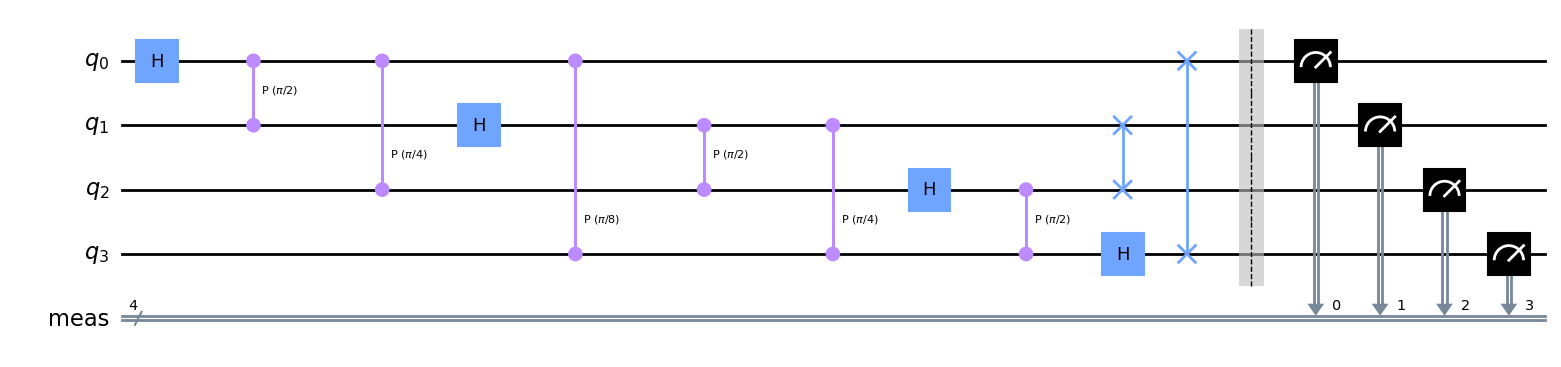

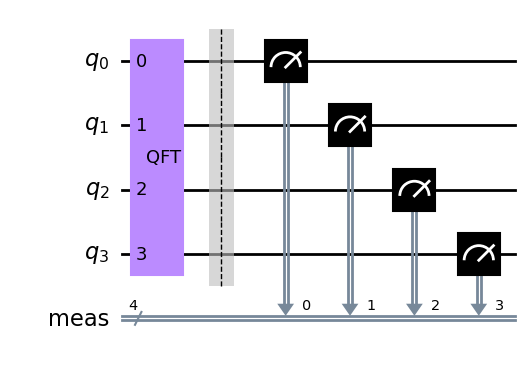

In [86]:
myQFTcirc = myQFT(4)
myQFTcirc.measure_all()

qiskitQFTcirc = QFT(4)
qiskitQFTcirc.measure_all()


display(myQFTcirc.draw(output = "mpl"))

display(qiskitQFTcirc.draw(output = "mpl"))

In [87]:
myQFTcounts = execute(myQFTcirc, backend=sim_count).result().get_counts()
qiskitQFTcounts = execute(qiskitQFTcirc, backend=sim_count).result().get_counts()

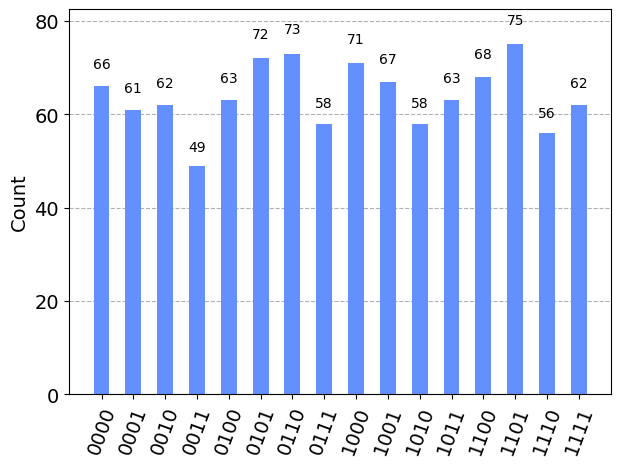

In [88]:
plot_histogram(myQFTcounts)

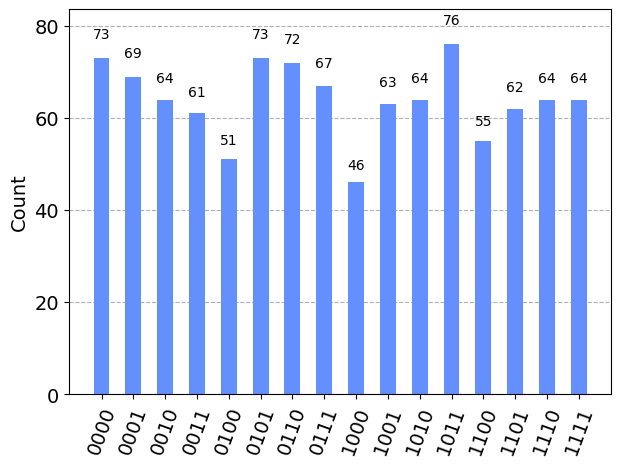

In [89]:
plot_histogram(qiskitQFTcounts) # discraprancy due to random number draw, i am not sure about how to fix the random seed

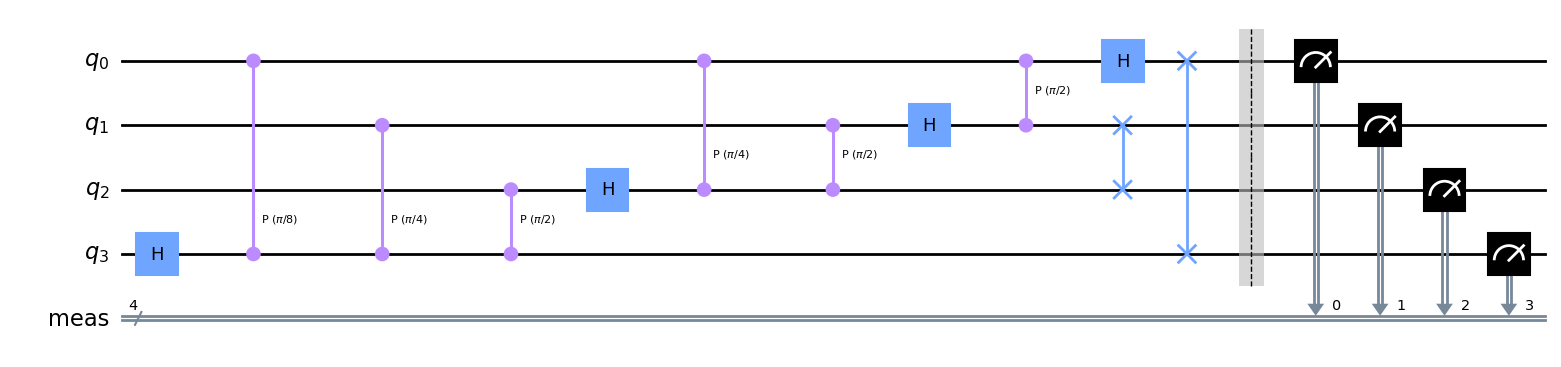

In [99]:
### This is the code given in the qiskit textbook 

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qc = QuantumCircuit(4)

textbookQFTcirc= qft(qc, 4)
textbookQFTcirc.measure_all()

textbookQFTcirc.draw(output="mpl")


In [100]:
textbookQFTcounts = execute(textbookQFTcirc, backend=sim_count).result().get_counts()

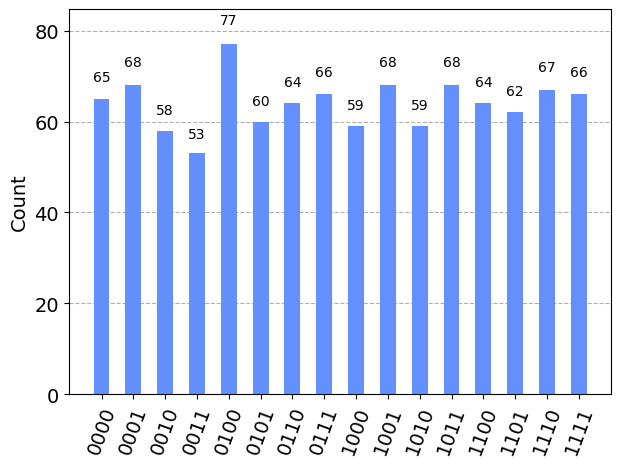

In [101]:
plot_histogram(textbookQFTcounts)